# Multi-label Keywords Extraction using Transformers(BERT)

In [1]:
! pip install pytorch-transformers
! pip install -q pytorch-lightning
! pip install -q bs4
! pip install -q transformers

     |████████████████████████████████| 176 kB 15.2 MB/s 
     |████████████████████████████████| 1.2 MB 87.3 MB/s 
     |████████████████████████████████| 131 kB 77.0 MB/s 
     |████████████████████████████████| 895 kB 61.3 MB/s 
     |████████████████████████████████| 7.8 MB 47.6 MB/s 
     |████████████████████████████████| 79 kB 8.8 MB/s 
     |████████████████████████████████| 138 kB 68.6 MB/s 
     |████████████████████████████████| 127 kB 65.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 916 kB 16.6 MB/s 
     |████████████████████████████████| 829 kB 66.1 MB

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import re
import time
import copy

from bs4 import BeautifulSoup
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.utils.data import Dataset
from torchvision import datasets
from transformers import BertConfig,BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from pytorch_transformers.optimization import AdamW, WarmupLinearSchedule
import pytorch_lightning as pl
from tqdm import tqdm_notebook, trange
from transformers import BertModel,BertTokenizer

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# mounting to google drive in order to access data in google colab
drive.mount('/content/drive')

Mounted at /content/drive


# Basic Data Exploration

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Final_Project_DL/sample_train.csv',encoding='latin-1',usecols=['Tags'])
df['Tags']= df['Tags'].astype(str).apply(lambda x:re.sub("-"," ",x).split())
tags = [item for sublist in df['Tags'].tolist() for item in sublist]
# count of unique tags
len(set(tags))

13203

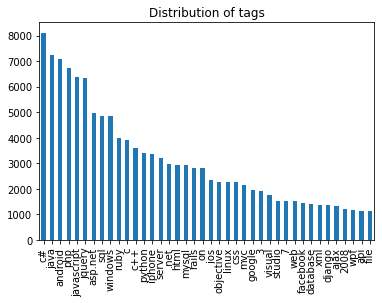

In [6]:
# frequency of the top 40 tags 
temp = pd.DataFrame({'Tags': tags})
temp['Tags'].value_counts()[:40].plot(kind='bar')
plt.title('Distribution of tags');

In [7]:
sum(temp['Tags'].value_counts()[:10].tolist())/sum(temp['Tags'].value_counts().tolist())

0.1645652841281096

In [8]:
top_tags = temp['Tags'].value_counts().keys()[0:10]
top_tags

Index(['c#', 'java', 'android', 'php', 'javascript', 'jquery', 'asp.net',
       'sql', 'windows', 'ruby'],
      dtype='object')

# Data Loading and Pre-Processing

In [9]:
def seperate_tags(tags):
  # takes a dataframe column of stringed tags and return a set of unique tags
  tags = tags.astype(str).apply(lambda x:re.sub("-"," ",x).split())
  tags = tags.transform(lambda x: set(x))
  return tags

In [10]:
def pre_process(text):
  # do all required pre-processing
  text = BeautifulSoup(text).get_text()
  text = text.lower()
  text = re.sub("[^a-z]", " ", text)
  tokens = text.split()
  return " ".join(tokens)

In [11]:
def fit_transform_target(y):
  # encodes a multilabel target y and returns the transformed onehotencoded vector
  mlb = MultiLabelBinarizer()
  return mlb.fit_transform(y), mlb

In [12]:
def preproces_df(df, top_tags):
  # loads and preprocesses the data to limit the required RAM
  question = []
  tags = []
  unqiue_tags = set() #{}
  lst_top_tags = list(top_tags)
  df['Tags'] = seperate_tags(df['Tags'])
  for i in range(len(df['Tags'])):
    temp=[]
    for tag in df['Tags'][i]:
        if tag in lst_top_tags:
            temp.append(tag)
            unqiue_tags.add(tag)
    
    
    if(len(temp)>0):
      question.append(pre_process(df['Body'][i]))
      tags.append(temp)
  
  encoded_tags, target_encoder = fit_transform_target(tags)

  return question, encoded_tags, target_encoder

In [13]:
# read the dataframe directly into the preprosseing function to save memory
questions, encoded_tags, target_encoder = preproces_df(pd.read_csv('/content/drive/MyDrive/Final_Project_DL/sample_train.csv',encoding='latin-1'), top_tags)

In [14]:
encoded_tags.shape

(46072, 10)

In [15]:
# splits into train, test and validation
x_train, x_test, y_train, y_test = train_test_split(questions, encoded_tags, test_size=0.1, random_state=1,shuffle=True)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=1,shuffle=True)

In [16]:
len(x_train) ,len(x_validation), len(x_test)

(33171, 8293, 4608)

# BERT preperation with Dataset, Dataloader and LightningDataModule

In [17]:
# the dataset class
class StackExchangeDataset(Dataset):
    def __init__(self, questions, encoded_tags, tokenizer, max_len):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.questions = questions
        self.tags = encoded_tags
        
    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx] 
        
        inputs = self.tokenizer.encode_plus(
            question,
            None,
            # adds the [CLS] start-of-sentence token 
            # and [SEP] separates the sentence token
            # same format as used in pretraining BERT
            add_special_tokens=True,
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            # return the attention mask for our model
            return_attention_mask= True,
            # truncate data beyond max length (300)
            truncation=True,
            # returns a pytorch tensor
            return_tensors = 'pt'
          )
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()

        tag = self.tags[idx]

        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(tag, dtype=torch.float)
            
        }

In [18]:
# borrowed from https://medium.com/analytics-vidhya/multi-label-text-classification-using-transformers-bert-93460838e62b
class StackExchangeModule (pl.LightningDataModule):  
    def __init__(self, x_train, y_train, x_validation, y_validation, x_test, y_test, tokenizer, batch_size=16, max_token_len=200):
        super().__init__()
        self.tr_text = x_train
        self.tr_label = y_train
        self.val_text = x_validation
        self.val_label = y_validation
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self):
        self.train_dataset = StackExchangeDataset(questions=self.tr_text, encoded_tags=self.tr_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.val_dataset = StackExchangeDataset(questions=self.val_text, encoded_tags=self.val_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset = StackExchangeDataset(questions=self.test_text, encoded_tags=self.test_label, tokenizer=self.tokenizer,max_len = self.max_token_len)     
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size = self.batch_size,shuffle = True , num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,batch_size= 16)

    def test_dataloader(self):
        return DataLoader(self.test_dataset,batch_size= 16)
    

In [19]:
# initialize the BERT tokenizer for our selected bert-base-cased model
BERT_model = "bert-base-cased" 
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_model)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
max_word_cnt = 300
quest_cnt = 0

for question in questions:

    #  to use Bert_tokenizer we need to covert the appropriate format 
    #  Bert_tokenizer adds tokens [CLS] and [SEP] and [PAD] to obtain the corresponding embedding
    input_ids = Bert_tokenizer.encode(question, add_special_tokens=True)

    # updates maximum sentence length.
    if len(input_ids) > max_word_cnt:
        quest_cnt +=1

print(f'# Question having word count > {max_word_cnt}: is  {quest_cnt}')

Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors


# Question having word count > 300: is  7900


In [21]:
max_len = 300
batch_size = 32
n_epochs = 5

StackExchange_module = StackExchangeModule(x_train, y_train, x_validation, y_validation, x_test, y_test, Bert_tokenizer, batch_size, max_len)
StackExchange_module.setup()

# BERT Model

In [22]:
# the BERT  classifier model 
class BERTClassifier(pl.LightningModule):
    def __init__(self, n_classes=10, steps_per_epoch=None, n_epochs=3, lr=2e-5 ):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_model, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes)
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self,input_ids, attn_mask):
        output = self.bert(input_ids = input_ids ,attention_mask = attn_mask)
        output = self.classifier(output.pooler_output)
                
        return output
    
    
    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }


    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters() , lr=self.lr)
        warmup_steps = self.steps_per_epoch//3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)

        return [optimizer], [scheduler]

In [23]:
# set up BERTClassifier model
steps_per_epoch = len(x_train)//batch_size
model = BERTClassifier(n_classes=10, steps_per_epoch=steps_per_epoch,n_epochs=n_epochs,lr=2e-05)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [141]:
trainer = pl.Trainer(max_epochs = n_epochs , gpus = 1,progress_bar_refresh_rate = 30)
trainer.fit(model, QTdata_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 108 M 
1 | classifier | Linear            | 7.7 K 
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
108

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


In [142]:
trainer.test(model,datamodule=QTdata_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of c

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.20340345799922943}
--------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


[{'test_loss': 0.20340345799922943}]

# Test Model Performance

In [148]:
from torch.utils.data import TensorDataset

# perform the same tokenization as previously on the test set
input_ids = []
attention_masks = []


for quest in x_test:
    encoded_quest =  Bert_tokenizer.encode_plus(
                    quest,
                    None,
                    add_special_tokens=True,
                    max_length= max_len,
                    padding = 'max_length',
                    return_token_type_ids= False,
                    return_attention_mask= True,
                    truncation=True,
                    return_tensors = 'pt'      
    )
        
    input_ids.append(encoded_quest['input_ids'])
    attention_masks.append(encoded_quest['attention_mask'])
    
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test)

# load the data into the DataLoader.
pred_data = TensorDataset(input_ids, attention_masks, labels)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=64)

In [149]:
# use BERT model to predict on test set
model = model.to(device)
model.eval()

pred_outs, true_labels = [], []

for batch in pred_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_attn_mask, b_labels = batch
 
    with torch.no_grad():
        pred_out = model(b_input_ids,b_attn_mask)
        pred_out = torch.sigmoid(pred_out)
        pred_out = pred_out.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

    pred_outs.append(pred_out)
    true_labels.append(label_ids)

In [150]:
# combine the results into a list 
flat_pred_outs = np.concatenate(pred_outs, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

In [151]:
# convert probabilities into 0 or 1 based on a threshold value
def classify(pred_prob,thresh_probabilty):
     # 0.4 best threshold
    # classifies the target as 1 or 0 based on the threshold value 0.5
    y_pred = []

    for tag_label_row in pred_prob:
        temp=[]
        for tag_label in tag_label_row:
            if tag_label >= thresh_probabilty:
                temp.append(1) 
            else:
                temp.append(0)
        y_pred.append(temp)

    return y_pred

In [152]:
y_true = flat_true_labels.ravel() 

# Model Performance

In [153]:
# predictions for optimal threshold
y_pred_labels = classify(flat_pred_outs,0.4)
y_pred = np.array(y_pred_labels).ravel()

In [162]:
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3798
           1       0.79      0.46      0.59       422

    accuracy                           0.93      4220
   macro avg       0.87      0.73      0.77      4220
weighted avg       0.93      0.93      0.93      4220



In [164]:
# reverses the target encoder 
y_pred = target_encoder.inverse_transform(np.array(y_pred_labels))
y_act = target_encoder.inverse_transform(flat_true_labels)

df = pd.DataFrame({'Body':x_test,'Actual Tags':y_act,'Predicted Tags':y_pred})

# a sample of how our model would predict tags for 20 questions
pd.set_option('display.max_colwidth', -1)
df.sample(10)

,Body,Actual Tags,Predicted Tags
66,being new to android development c oop dev i r...,"(android,)","(android,)"
318,i was kindly helped by jonathan over here http...,"(javascript,)","(javascript,)"
198,my question relates to the underlying renderin...,"(java,)","(java,)"
212,when writing javascript i often forget some pr...,"(javascript,)","(javascript,)"
400,if this hasclass white console log white equat...,"(jquery,)",()
298,is it possible to call c function from rd part...,"(php,)","(php,)"
280,so say i have a file page php html hello php e...,"(php,)","(php,)"
296,in my app i want to create something like this...,"(android,)","(android,)"
365,typing first time here before i found many hel...,"(python,)",()
134,i have one fragmentactivity that holds viewpag...,"(android,)","(android,)"
